# DeepLabv3 transfer learning implementation


## Import pretrained model Deeplabv3

In [1]:
from torch.utils.data import Dataset
import torchvision.transforms.functional as F
import torch
import os

# os.environ['CUDA_LAUNCH_BLOCKING']='1'

%matplotlib widget

from utils.function_lib import *
from utils.LiverDataset import *
from utils.DiceLoss import *

from ModelBuilder.ResNet152_DeepLab import ResNet152DeepLab
from ModelBuilder.ResNeXt101_DeepLab import ResNeXt101DeepLab
from ModelBuilder.DenseNet.DenseNet201_DeepLab import DenseNet201DeepLab
from ModelBuilder.Inception.InceptionV3_DeepLab import InceptionV3DeepLab
from ModelBuilder.ConvNeXt.ConvNeXt_DeepLab import ConvNeXtDeepLab
from ModelBuilder.unet import UNet

from FusionSystem.FusionNetwork import FusionNetwork

In [2]:
transform_image = transforms.Compose(
    [
     transforms.ToPILImage(),
     transforms.Resize(256, interpolation=transforms.functional.InterpolationMode.BILINEAR, antialias = True),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.2], std=[0.2])
     ])
transform_mask = transforms.Compose(
    [
     transforms.ToTensor()
     ])

path = 'G:/MachineLearning/liver-database/'
save_path = 'G:/MachineLearning/models/'
#path = 'segmentations/'
dataset_learn = LiverDataset(path + 'validation/', transform_image=transform_image, transform_mask=transform_mask)
dataloader_learn = torch.utils.data.DataLoader(dataset_learn, batch_size=2, shuffle=True, num_workers=8)

dataset_test = LiverDataset(path + 'testing/', transform_image=transform_image, transform_mask=transform_mask)
dataloader_test = torch.utils.data.DataLoader(dataset_learn, batch_size=2, shuffle=True, num_workers=8)

## Vizualizam o imagine din dataset

In [3]:
model_checkpoint = 'G:/MachineLearning/models/ConvNeXt/ConvNeXt_checkpoint.pt'
# # model = torch.load(model_checkpoint, map_location=torch.device('cpu'))
model = ConvNeXtDeepLab()
checkpoint = torch.load(model_checkpoint, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
device = torch.device('cpu')
model.to(device)

ConvNeXtDeepLab(
  (FeatureExtractor): ConvNeXt(
    (downsample_layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm()
      )
      (1): Sequential(
        (0): LayerNorm()
        (1): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
      )
      (2): Sequential(
        (0): LayerNorm()
        (1): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), dilation=(2, 2))
      )
      (3): Sequential(
        (0): LayerNorm()
        (1): Conv2d(512, 1024, kernel_size=(2, 2), stride=(1, 1), dilation=(2, 2))
      )
    )
    (stages): ModuleList(
      (0): Sequential(
        (0): Block(
          (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm()
          (pwconv1): Linear(in_features=128, out_features=512, bias=True)
          (act): GELU()
          (pwconv2): Linear(in_features=512, out_features=128, bias=True)
          (drop_path

torch.Size([512, 512])
tensor(1.)


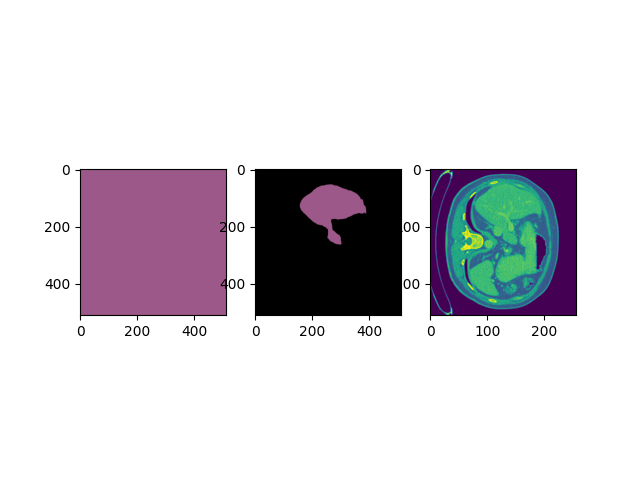

In [4]:
image, mask = dataset_learn.__getitem__(583)
# print(f"Min: {torch.min(image)}, Max: {torch.max(image)}")
# m, s = np.mean(image.numpy()), np.std(image.numpy())
# print(f"Mean: {m}, STD: {s}")
show_model_seg(model, dataset_learn, 583)